In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import os

# Preparing Data

In [3]:
file_path1 = 'Tropics_tp&cape_5*5.nc'
file_path2 = 'Tropics_cin_5*5.nc'
  
#Opening dataset for tropics                                   
dsT1 = xr.open_dataset(file_path1)
dsT2 = xr.open_dataset(file_path2)

merged_ds = xr.merge([dsT1, dsT2])

daily_meanT = merged_ds.resample(time='D').mean(dim='time')
avg_dsMT = merged_ds.mean(dim=['latitude', 'longitude'])  

# Visualising seasonal precipitation for the region 

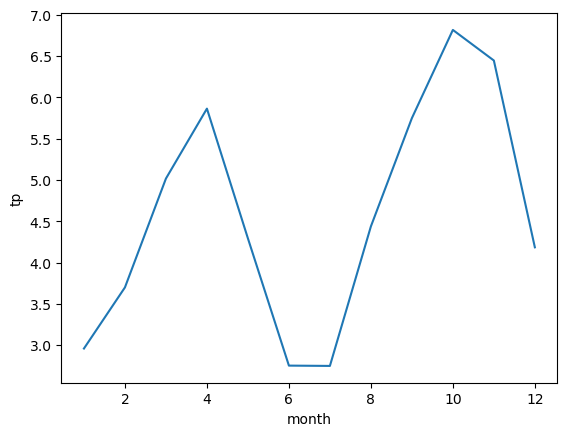

In [4]:
tp_mmpd = merged_ds['tp']*1e3*24
tp_spatial = tp_mmpd.mean(dim = ['latitude','longitude'])
tp_seasonal = tp_spatial.groupby('time.month').mean()
tp_seasonal.plot()

# Seasonal plot examination

Upon examination of the seasonal precipitation patterns across the central African grid cell, where convection significantly influences precipitation, it becomes evident that the region experiences two distinct monsoon seasons: the first occurring in MAM and the second in SON, with JJA being characterized by the lowest precipitation levels.

# Extracting seasonal data

In [5]:

winter_data = avg_dsMT.sel(time=avg_dsMT['time.season']=='DJF')
Monsoon1 = avg_dsMT.sel(time=avg_dsMT['time.season']=='MAM')
DriestMonths = avg_dsMT.sel(time=avg_dsMT['time.season']=='JJA')
Monsoon2 = avg_dsMT.sel(time=avg_dsMT['time.season']=='SON')

# Obtaining data binned by CAPE for the four seasons

In [6]:
#Creating a loop to obtain the binned plots for the seasons
cape_bins = np.linspace(0, 2500, 17)
cins = []
tps = []
for data in (DriestMonths, winter_data, Monsoon2, Monsoon1):
    positive_precip = data['tp'].where((data['tp']*24000) > 1.0)
    cape_positive_precip = data['cape'].where((data['tp']*24000) > 1.0)
    binned_precipitation = positive_precip.groupby_bins(cape_positive_precip, bins=cape_bins)
    binned_cin = data['cin'].groupby_bins(cape_positive_precip, bins=cape_bins)
    avgcin = binned_cin.mean()
    avgtp = binned_precipitation.mean()
    cape_mid = (cape_bins[1:] + cape_bins[:-1])/2
    cins.append(avgcin)
    tps.append(avgtp)

# Looping to create binned precipition and CIN panel plots 

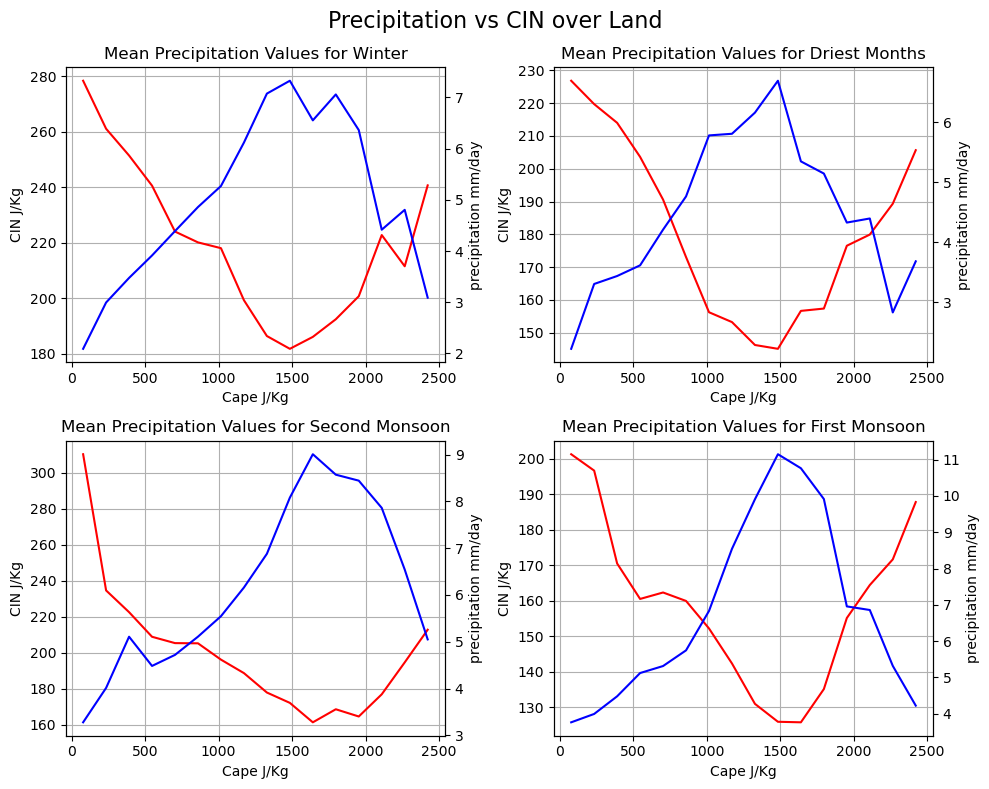

In [7]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, j, season, avgcin, avgtp in ((0, 0, "Winter", cins[1], tps[1]), (0, 1, "Driest Months", cins[0], tps[0]), (1, 0, "Second Monsoon", cins[3], tps[3]), (1, 1, "First Monsoon", cins[2], tps[2])):

    axs[i, j].plot(cape_mid, avgcin, color='r', label=f'{season}')
    axs[i, j].set_xlabel('Cape J/Kg')
    axs[i, j].set_ylabel('CIN J/Kg')
    axs[i, j].set_title(f'Mean Precipitation Values for {season}')
    axs[i, j].grid(True)
    ax2 = axs[i, j].twinx()  
    ax2.plot(cape_mid, avgtp*24000, 'b-', label='cape')
    ax2.set_ylabel('precipitation mm/day')
    ax2.tick_params(axis='y')

plt.suptitle("Precipitation vs CIN over Land", fontsize=16)
plt.tight_layout()
plt.show()

# Panel plot examination

## CAPE 
Upon reviewing the panel plots, it is evident that optimal conditions for substantial precipitation, exceeding 5 mm/day, occur when CAPE values range from 1000 to 1750 J/kg. It's crucial to acknowledge that this threshold is comparatively lower than actual regional rainfall due to the utilization of reanalysis data and the subsequent averaging process across latitude and longitude.

## CIN
In terms of CIN, a discernible trend emerges, indicating that elevated CIN levels significantly suppress precipitation. However, it is noteworthy that a positive CIN value within the approximate range of 80 to 140 J/kg is a prerequisite for triggering high-precipitation events. This condition typically coincides with CAPE values hovering around 1500 J/kg